In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product i.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_i= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_i.shape

(60, 1)

In [5]:
sales_i.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_i['Sales'].sum()

5783407

Text(0.5, 1.0, 'Product I')

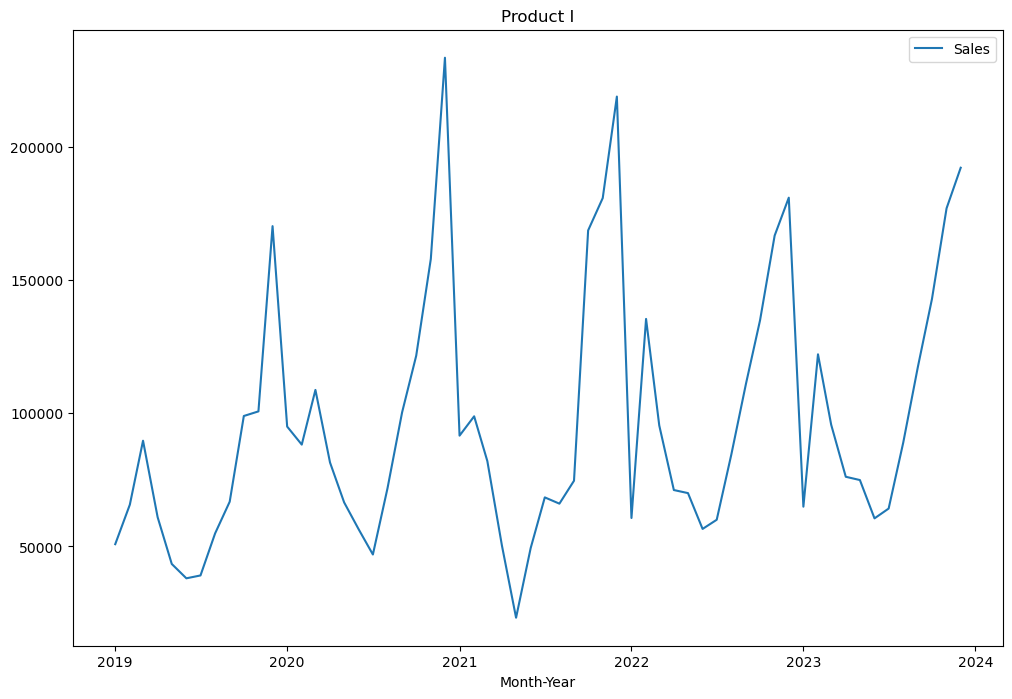

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i)
plt.title('Product I')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_i)

ADF Statistics: -2.5790376657087335
p- value: 0.09740761251652458
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_i_diff= sales_i.diff().dropna()

Text(0.5, 1.0, 'Product I- First Difference')

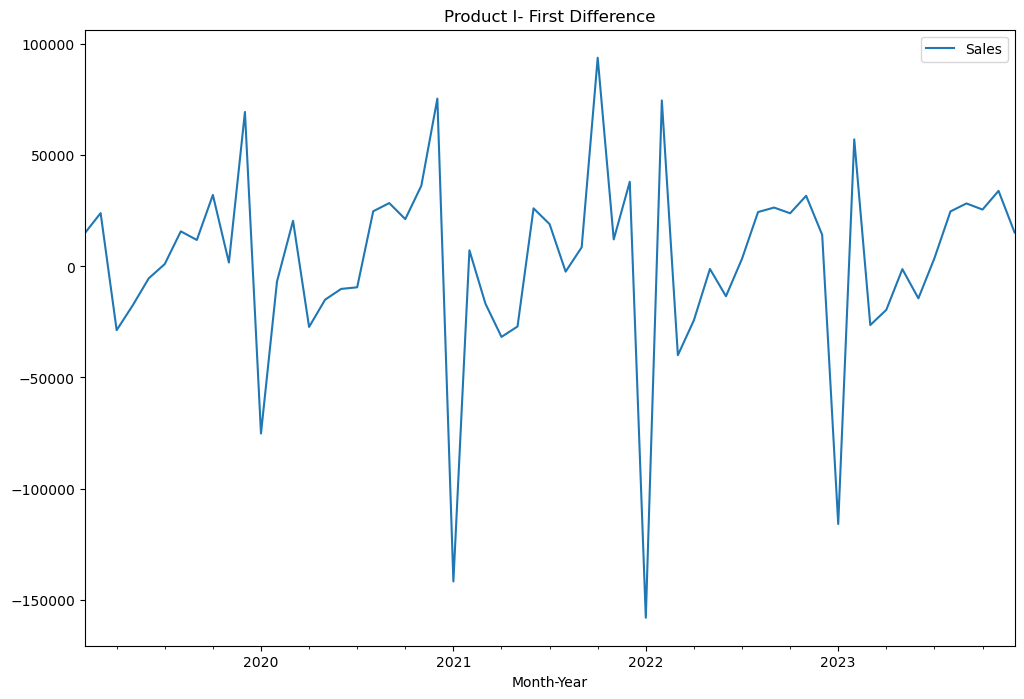

In [11]:
sales_i_diff.plot(figsize=(12,8))
plt.title('Product I- First Difference')

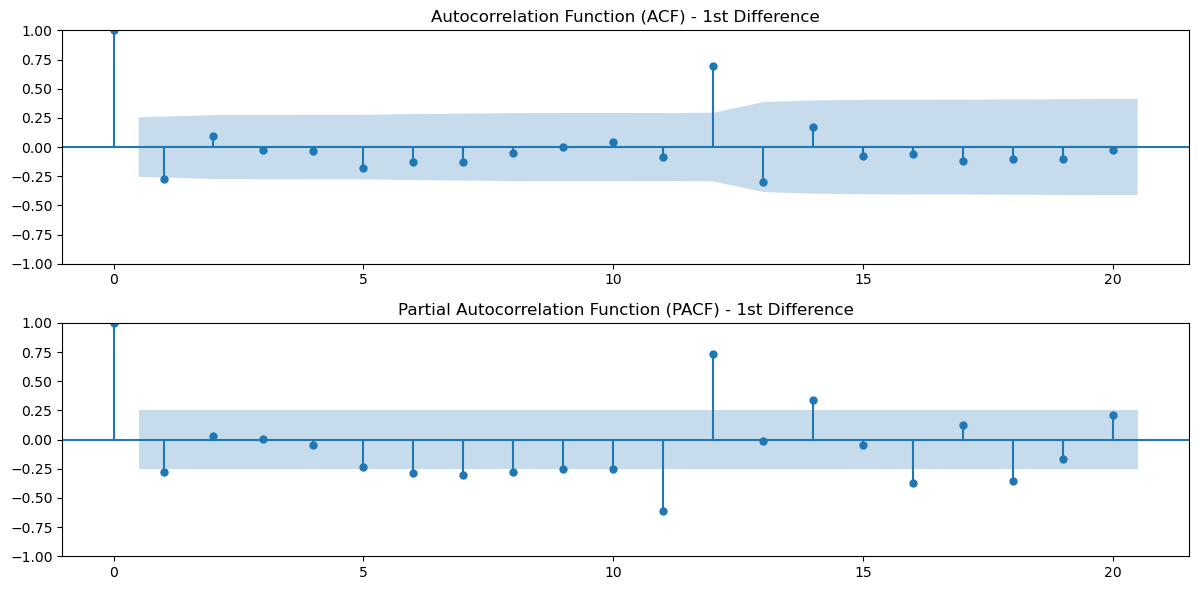

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_i_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_i_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_i_diff)

ADF Statistics: -3.6173278718862623
p- value: 0.005438267272077221
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_i[:48]
test=sales_i[48:]

In [15]:
len(train)

48

In [16]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(1,1,0),(1,1,1),(1,1,2),(2,1,0), (2,1,1), (2, 1, 2),(3,1,0),(3,1,1),(3,1,2),(4,1,0),(4,1,1),(4,1,2),(5,1,0),(5,1,1),(5,1,2)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_i, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_i)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1137.337430  1150.288463  19281.153761  9.727604e+08  31189.106732
17  5  2  1138.704384  1153.505565  18298.162279  9.330945e+08  30546.595516
3   1  0  1140.990133  1144.690428  73970.295274  6.954031e+09  83390.835576
1   0  1  1141.466168  1145.166463  72283.783476  6.640216e+09  81487.520762
16  5  1  1141.575436  1154.526469  27303.868500  1.379358e+09  37139.711912
10  3  1  1141.860646  1151.111384  40157.336837  2.241327e+09  47342.653845
0   0  0  1142.072734  1143.922882  76378.250000  7.380229e+09  85908.258120
13  4  1  1142.621466  1153.722351  34582.855685  1.850266e+09  43014.713831
6   2  0  1142.847971  1148.398414  75820.477710  7.275846e+09  85298.568178
4   1  1  1142.877093  1148.427536  75448.050790  7.211669e+09  84921.545991
8   2  2  1143.116486  1152.367224  44872.982956  2.537512e+09  50373.719417
2   0  2  1143.436781  1148.987224  77643.459729  7.599860e+09  87177.174693

In [20]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -561.669
Date:                Thu, 09 May 2024   AIC                           1137.337
Time:                        18:37:08   BIC                           1150.288
Sample:                    01-01-2019   HQIC                          1142.211
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1505      0.342      3.360      0.001       0.479       1.822
ar.L2         -0.1878      0.430     -0.437      0.662      -1.031       0.655
ar.L3         -0.2289      0.457     -0.501      0.6

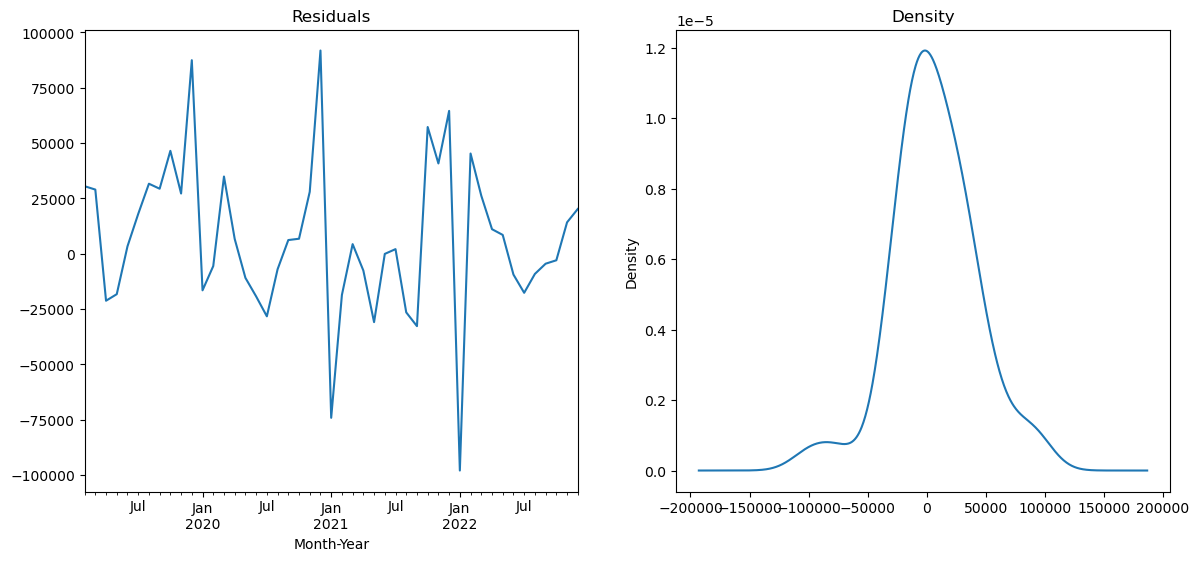

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

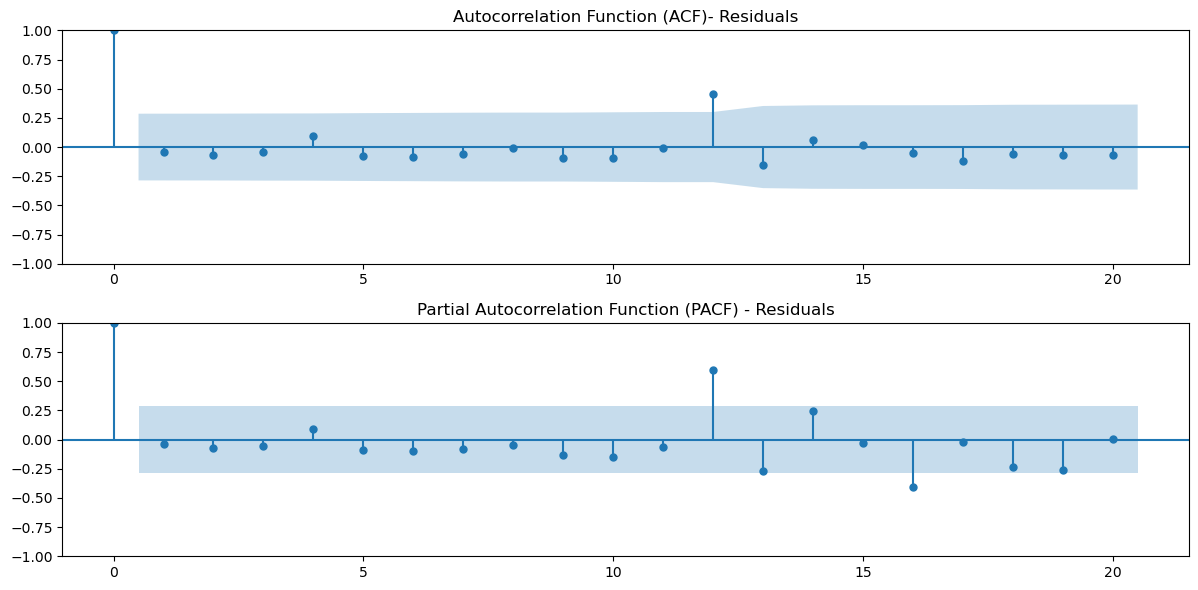

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

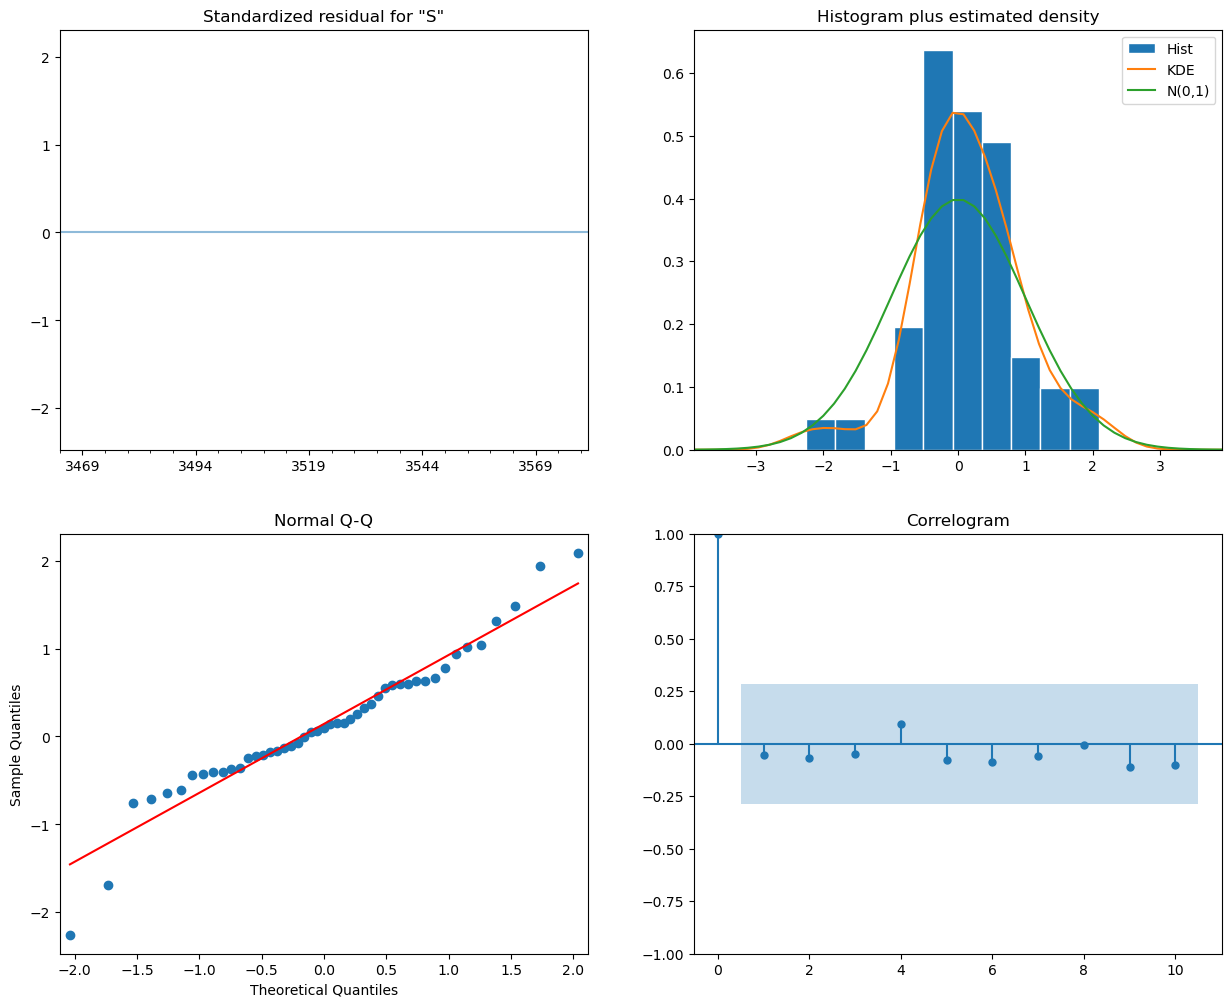

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_i['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_i.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_i)-1), dynamic = True)
sales_i['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product I')

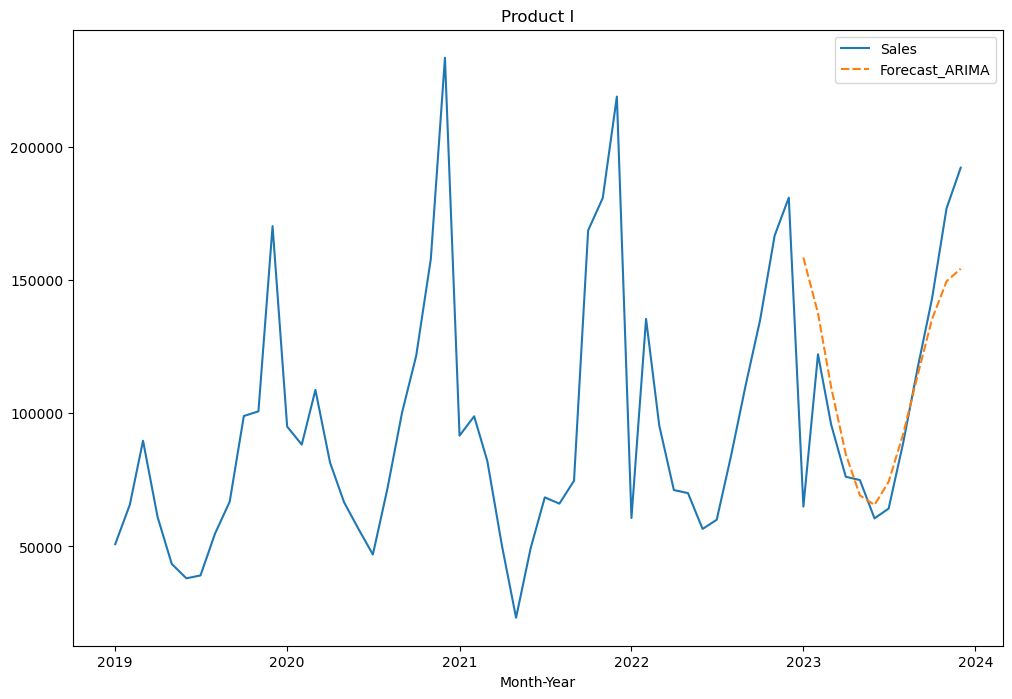

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i)
plt.title('Product I')

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 19281.153760926274
MAPE - ARIMA: 0.21740252572804689
MSE - ARIMA: 972760378.7209729
RMSE - ARIMA: 31189.106731693566


# SARIMA

In [28]:
import statsmodels.api as sm

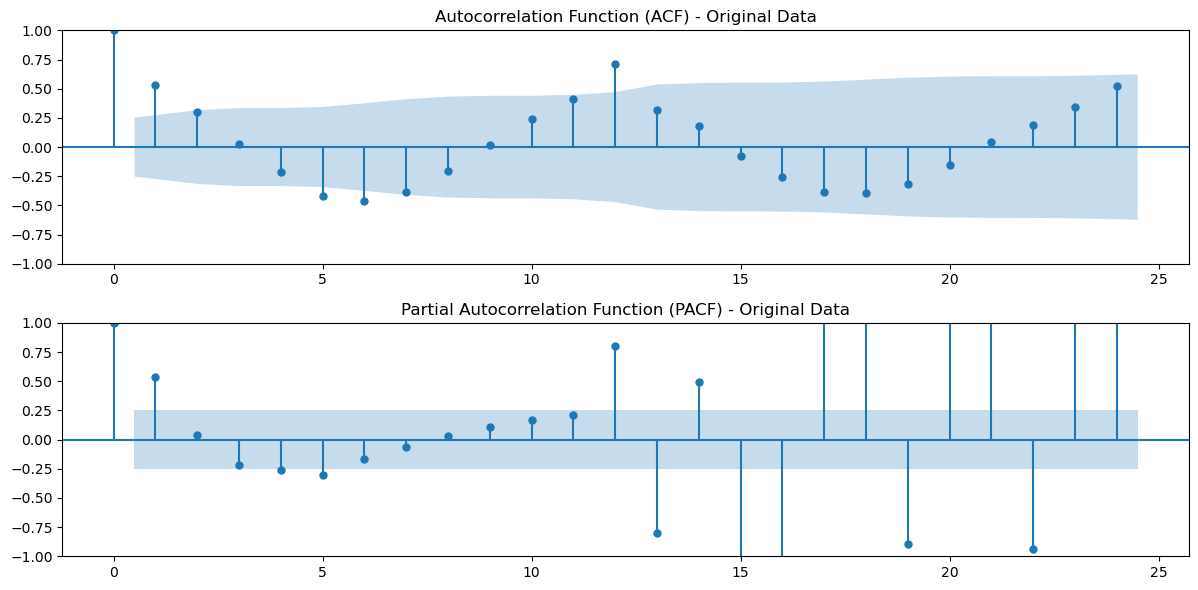

In [30]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_i['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_i['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

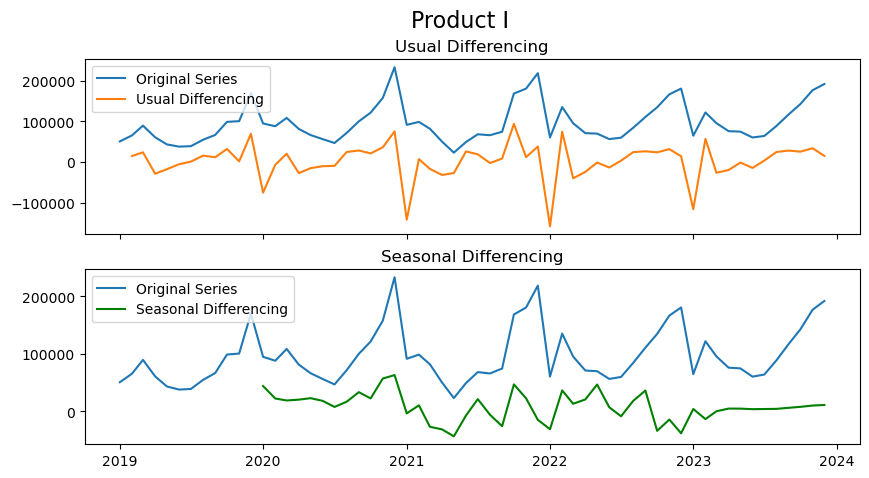

In [31]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_i['Sales'], label='Original Series')
axes[0].plot(sales_i['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_i['Sales'], label='Original Series')
axes[1].plot(sales_i['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product I', fontsize=16)
plt.show()

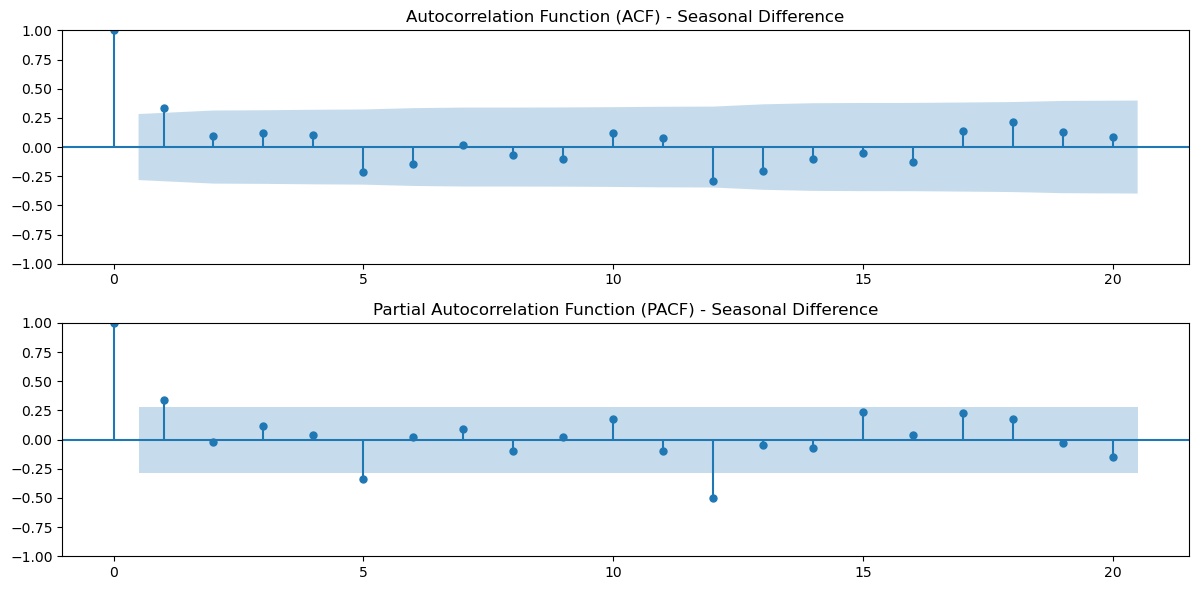

In [32]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_i['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_i['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

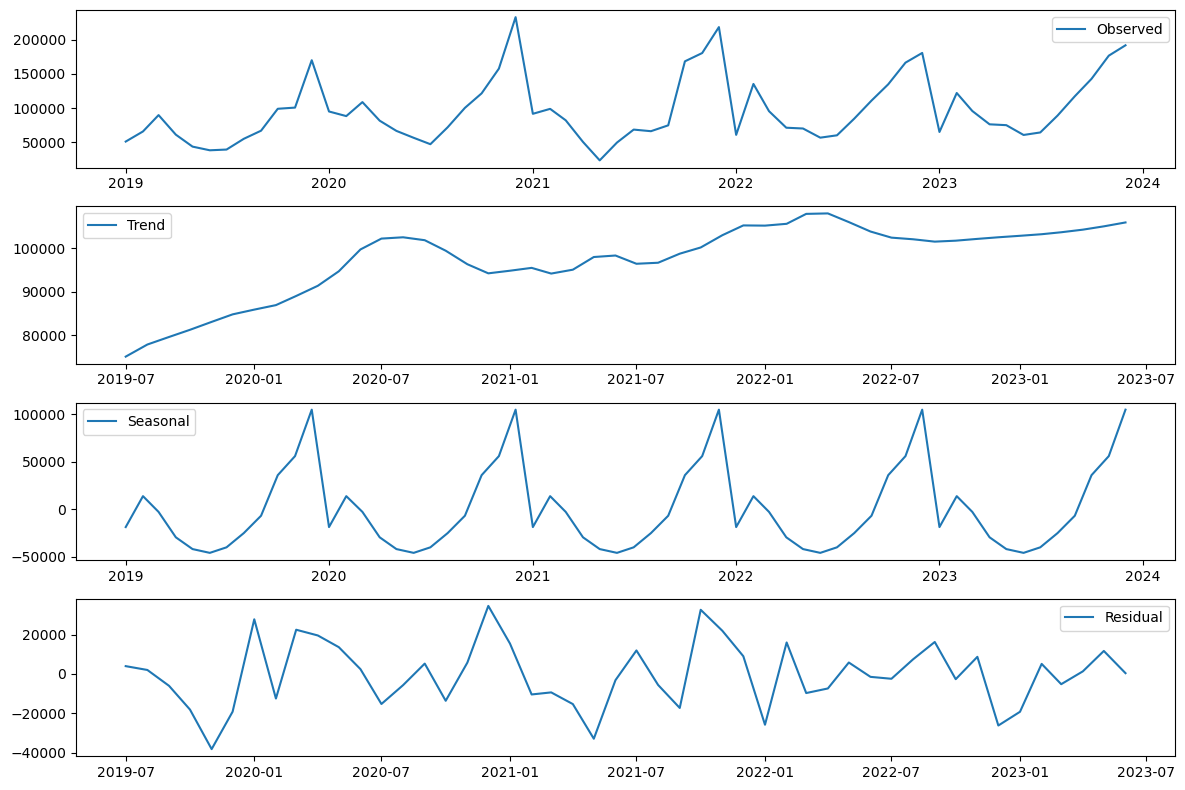

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_i['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [34]:
order_SARIMAX=[]
# Loop over P order
for P in range(4):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [35]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

   P  Q         aic         bic           mae           mse
0  0  0  831.009665  841.897101  14381.764684  2.432664e+08
1  0  1  832.749417  845.192201  12351.468197  2.029849e+08
2  1  0  832.785878  845.228663  12897.911239  2.145149e+08
6  3  0  833.914955  849.468436  17858.451475  4.121539e+08
4  2  0  834.463985  848.462117   7933.792997  1.087164e+08
3  1  1  834.730142  848.728274  12130.929735  1.968923e+08
5  2  1  835.184667  850.738148  10898.436936  1.262328e+08
7  3  1  835.913535  853.022364  18263.926152  4.264075e+08


In [36]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 2),seasonal_order=(0,1,0,12))
sarima_model=sarima.fit()

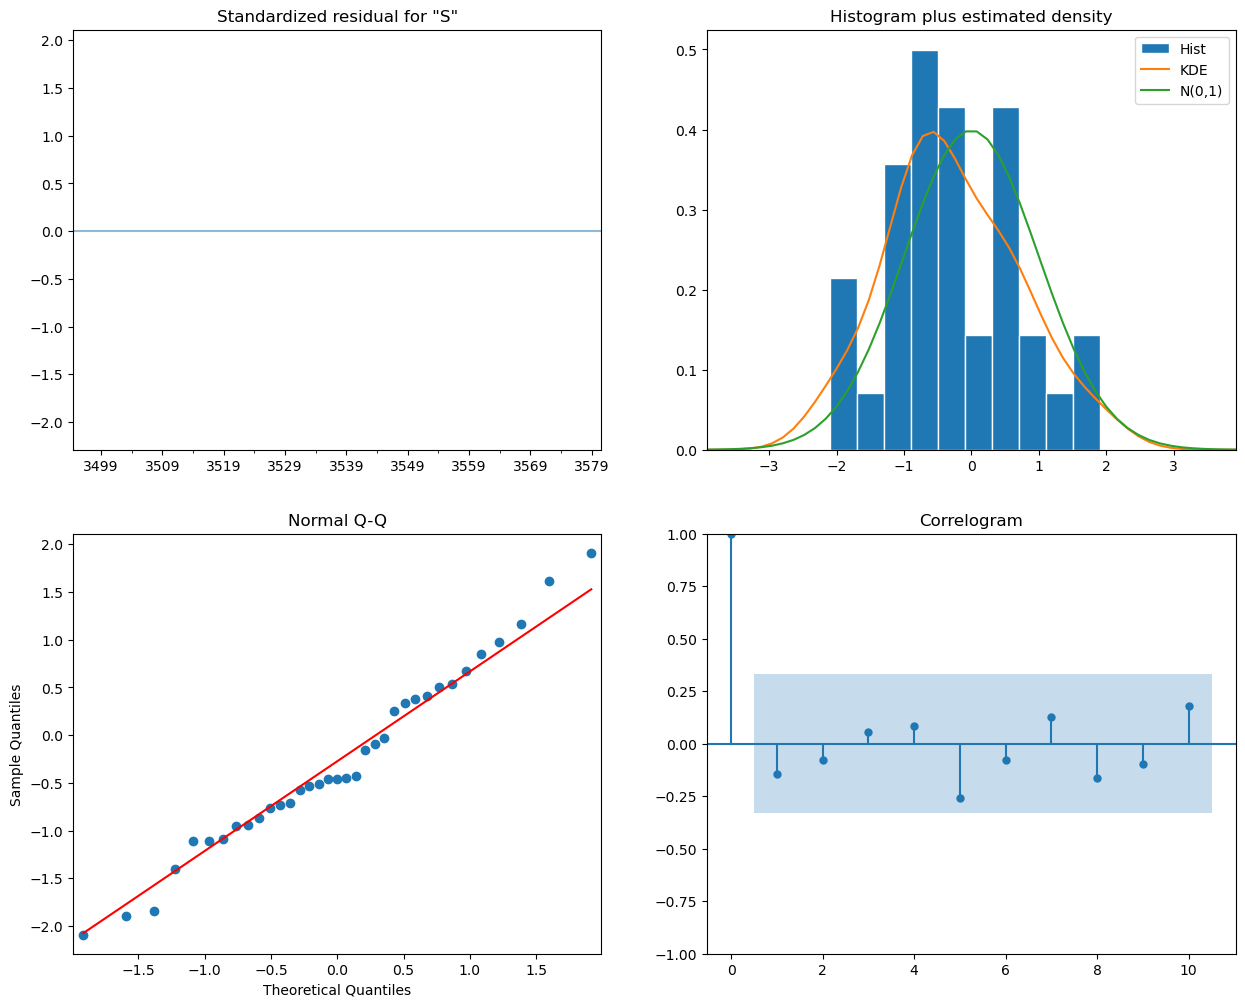

In [37]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
forecast_test_sarima=sarima_model.predict(start=48,end=59,dynamic=True)

In [39]:
sales_i['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product I')

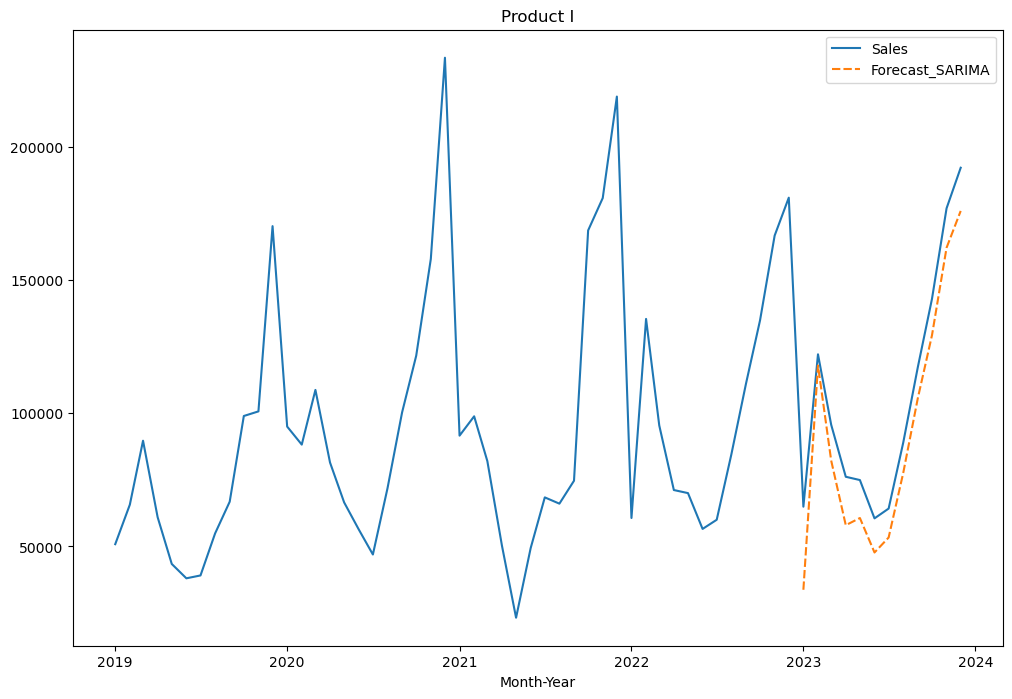

In [40]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i[['Sales','Forecast_SARIMA']])
plt.title('Product I')

In [41]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 14381.765
MAPE - SARIMA: 0.163
MSE - SARIMA: 243266412.873
RMSE - SARIMA: 15597.0


# AUTO-ARIMA

In [42]:
import pmdarima as pm

In [43]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=4 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=827.086, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=827.476, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=829.411, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=827.513, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=829.473, Time=0.30 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=829.397, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=830.512, Time=0.45 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=831.947, Time=1.04 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=829.551, Time=1.79 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=831.430, Time=1.77 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=833.330, Time=4.22 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=831.551, Time=2.00 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=833.430, Time=2.64 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=825.658, Time=0.07 sec
 ARIMA(0,1,1)(

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [44]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -409.063
Date:                             Thu, 09 May 2024   AIC                            824.125
Time:                                     18:41:38   BIC                            828.791
Sample:                                 01-01-2019   HQIC                           825.736
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5469      0.263      2.082      0.037       0.032       1.062
ma.L1         -0.8901      0.134     -6.634      0.000      -1.153      -0.627
sigma2      8.933e+08   9.66e-11   9.25e+18      0.000    8.93e+08    8.93e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.39   Prob(JB):                         0.55
Heteroskedasticity (H):               1.62   Skew:                             0.45
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.33e+34. Standard errors may be unstable.
"""

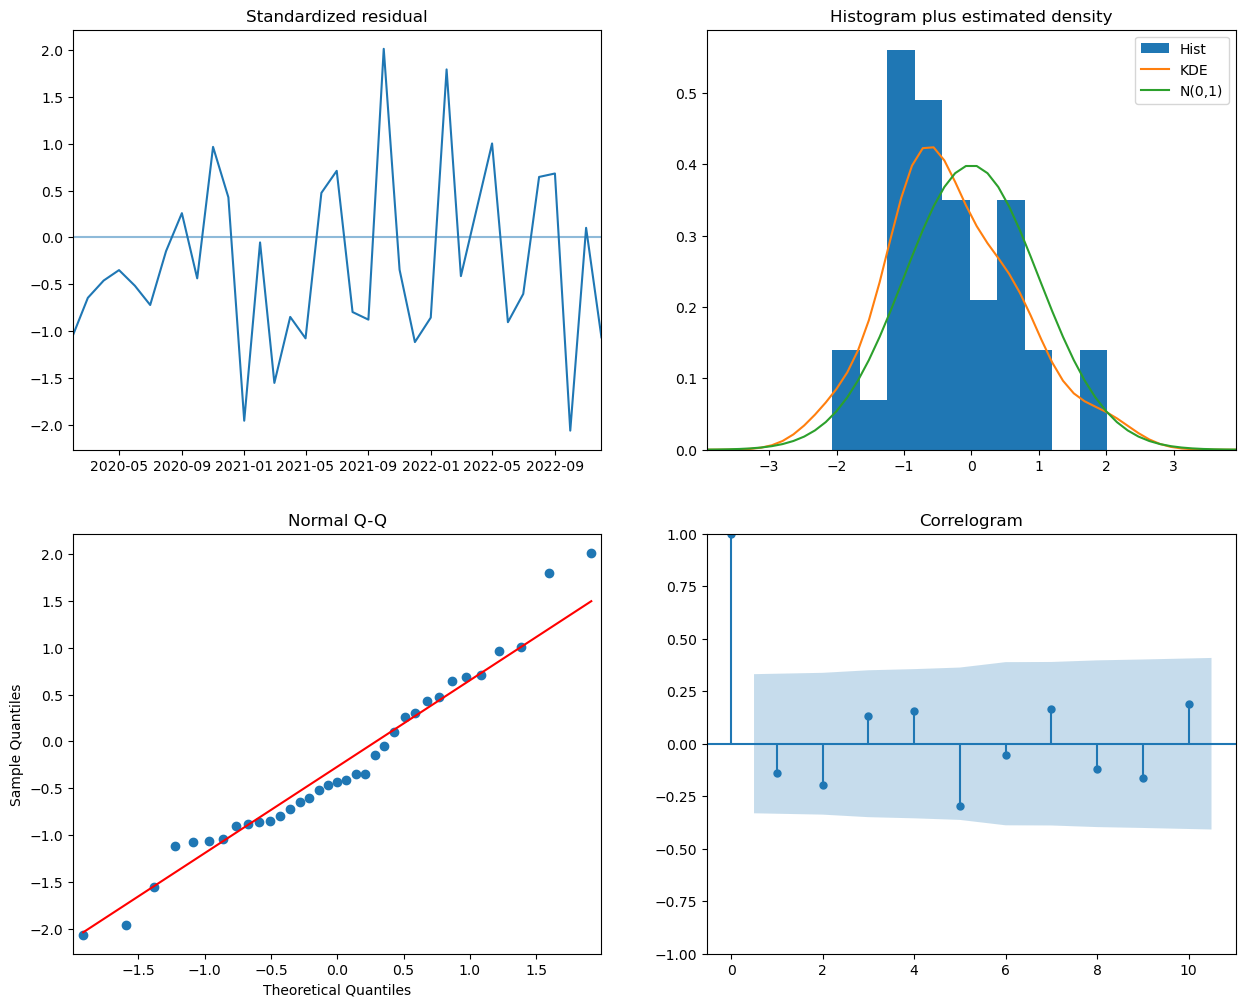

In [45]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [46]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_i['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_i.plot()

Text(0.5, 1.0, 'Product I')

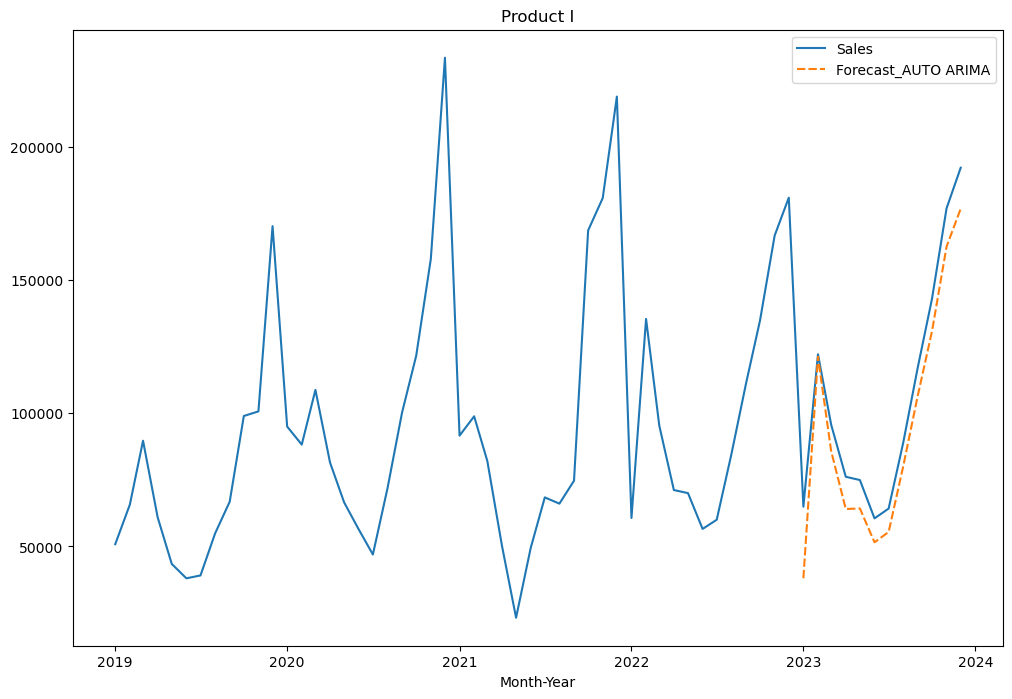

In [47]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product I')

In [48]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 11638.831320175823
MAPE - AUTO ARIMA: 0.12903924292009727
MSE - AUTO ARIMA: 168453368.30581394
RMSE - AUTO ARIMA: 12978.958675711005


In [49]:
sales_i.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,64906,158404.129591,33722.429337,38049.808476
2023-02-01,122096,137541.737447,117919.309333,121155.672756
2023-03-01,95682,109720.128298,82239.850496,85756.495906
2023-04-01,76134,84634.064229,57962.358119,64022.260553
2023-05-01,74900,69153.628763,60650.531273,64240.635618
2023-06-01,60518,65560.588323,47716.284893,51549.574242
2023-07-01,64200,74261.545418,53330.986874,55400.679365
2023-08-01,88953,92264.692679,77584.210509,80091.946001
2023-09-01,117297,114495.660131,105658.049785,106703.586565


In [50]:
sales_i.mean()

Sales                   96390.116667
Forecast_ARIMA         112084.077237
Forecast_SARIMA         92000.485316
Forecast_AUTO ARIMA     94743.418680
dtype: float64

In [51]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,19281.153761,0.217403,9.727604e+08,31189.106732
AUTO ARIMA,11638.831320,0.129039,1.684534e+08,12978.958676
SEASONAL ARIMA,14381.764684,0.162970,2.432664e+08,15597.000124


# TESTING

In [17]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=842.476, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=840.908, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=841.351, Time=0.24 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=842.423, Time=0.10 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=841.971, Time=0.16 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=841.615, Time=0.67 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=840.203, Time=0.27 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=840.456, Time=0.49 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=842.398, Time=0.81 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=838.923, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=838.769, Time=0.14 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=840.451, Time=0.30 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=839.234, Time=0.15 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=840.620, Time=0.28 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=840.919, Time=0.71 sec
 ARIMA(0,0

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [18]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -416.300
Date:                            Wed, 08 May 2024   AIC                            838.600
Time:                                    20:03:10   BIC                            843.351
Sample:                                01-01-2019   HQIC                           840.259
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4785.5369   4443.545      1.077      0.281   -3923.651    1.35e+04
ar.L1          0.2928      0.138      2.116      0.034       0.022       0.564
sigma2      6.606e+08      0.007   9.36e+10      0.000    6.61e+08    6.61e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.67   Prob(JB):                         0.66
Heteroskedasticity (H):               1.86   Skew:                             0.05
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+27. Standard errors may be unstable.
"""

In [19]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_i['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product I')

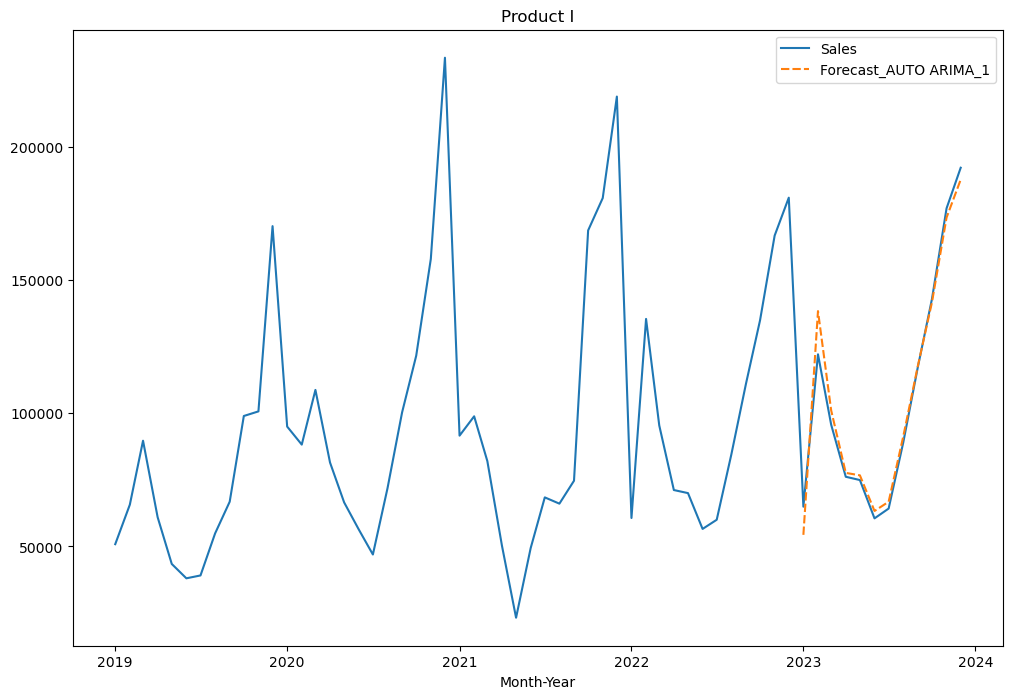

In [20]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product I')

In [21]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 4383.666395572744
MAPE - AUTO ARIMA: 0.04675963544893746
MSE - AUTO ARIMA: 38494965.62600728
RMSE - AUTO ARIMA: 6204.431128315253
